In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

In [2]:
gamma = 0.0138172

ribo_decay = 6.205e-6
prot_decay = 6.205e-6

r_R = 63
r_P = 63
l_R = 5000
l_P = 975

LHS = np.array([[1,1,1,0],
               [0,0,0,1]])

RHS = np.array([[2,1,0,0],
               [0,1,0,0]])

S = RHS - LHS   

def reaction_rates(volume, X, 
                   mu_ribo_synth= gamma*r_R/l_R,
                   mu_prot_synth= (1-gamma)*r_P/l_P, 
                   mu_ribo_decay= ribo_decay, 
                   mu_prot_decay= prot_decay):
    
    mu_vector = np.array([mu_ribo_synth, mu_prot_synth, mu_ribo_decay, mu_prot_decay])
    scaled_rates = np.power(X.repeat(LHS.shape[1],1)/volume,LHS).prod(axis=0)
    
    return mu_vector * scaled_rates * volume

def dZ_dt(state, t=0, volume=1e-18):
    
    Z = state.reshape(2*LHS.shape[0]+1, LHS.shape[0])
    
    phi = np.atleast_2d(Z[0]).T
    F = reaction_rates(volume=volume, X=phi)
    E = S @ np.sqrt(np.diag(F))
    J = ( (1/phi @ np.atleast_2d(F) ) * LHS).T
    A = S @ J
    
    V = Z[1:A.shape[0]+1]
    G = Z[A.shape[0]+1:]
    
    phidot = S @ F
    Vdot = A @ V + V @ A.T + E @ E.T
    
    Gdot = A @ G
    
    ode_list = np.vstack((phidot, Vdot, Gdot)).reshape(-1)
    
    return ode_list


In [3]:
class Trajectory:
    def get_init_counts(self, volume):
        # Linear scaling
        n_ribo, n_prot = volume, volume
        return n_ribo, n_prot

    def __init__(self, 
                 volume   = 1e-18, 
                 iterations=100000):
        
        final_time = 10000.
        
        self.volume     = volume
        self.iterations = iterations
        
        init_counts = np.array(self.get_init_counts(volume))
        init_cov    = np.eye(2) * volume * 0.01
        global_init = np.vstack([init_counts.reshape(1,2), init_cov, np.identity(2)])

        T = np.linspace(0, final_time, iterations)

        solved_odes = odeint(dZ_dt, y0=global_init.reshape(-1), t=T, args=(volume,)).reshape(-1,2*LHS.shape[0]+1, LHS.shape[0])

        n_species = len(init_counts)
        self.X_t = solved_odes[:,0,:]
        self.V_t = solved_odes[:,1:n_species+1,:]
        self.G_t = solved_odes[:,n_species+1:,:]
        self.cov_t = self.V_t[0] @ self.G_t.transpose(0,2,1)

        self.var_ribo = self.V_t[:,0,0]
        self.var_prot = self.V_t[:,1,1]
        self.cov_riboprot = self.V_t[:,0,1]

        self.cov_ribo_over_time = self.cov_t[:,0,0]
        self.cov_prot_over_time = self.cov_t[:,1,1]
        self.cov_riboprot_over_time = self.cov_t[:,0,1]

        self.rho_ribo = np.array([self.cov_ribo_over_time[t]/(np.sqrt(self.var_ribo[0])*np.sqrt(self.var_ribo[t])) for t in range(0,iterations)])
        self.rho_prot = np.array([self.cov_prot_over_time[t]/(np.sqrt(self.var_prot[0])*np.sqrt(self.var_prot[t])) for t in range(0,iterations)])

        self.mi_ribo = -0.5*np.log(1-self.rho_ribo**2)
        self.mi_prot = -0.5*np.log(1-self.rho_prot**2)


In [4]:
volumes = np.logspace(-3,3,10)
trajectories_by_volume = [Trajectory(volume=v) for v in volumes]

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log
/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in log


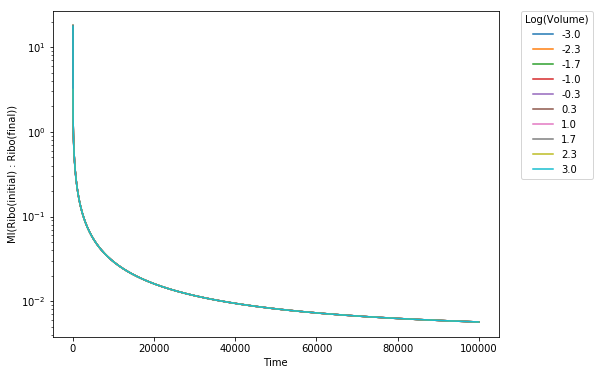

In [5]:
plt.figure(figsize=(8,6))
for i,traj in enumerate(trajectories_by_volume):
    plt.plot(traj.mi_ribo, label='%0.1f'%np.log10(traj.volume))
plt.yscale('log')
plt.ylabel('MI(Ribo(initial) : Ribo(final))')
plt.xlabel(r'Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Log(Volume)')
plt.show()